# Train Neural Network

## Dataset

- `__len__`: trả về số sample trong dataset, tương ứng len(dataset).
- `__getitem__`:  lấy ra sample thứ i trong dataset, tương ứng dataset[i].

![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-39.png?resize=1024%2C420&ssl=1)

Ví dụ như khi load dataset cifar10 từ torchvision.dataset

In [14]:
import torch

In [15]:
from torchvision import datasets

data_path = 'data'

# load dataset cifar10
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)

Files already downloaded and verified


In [16]:
# Check instance is Pytorch Dataset
print(isinstance(cifar10, torch.utils.data.Dataset))
# Get len
print(cifar10.__len__())
#Get an item
print(cifar10[0])

True
50000
(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F960816C790>, 6)


Text(0.5, 1.0, '6')

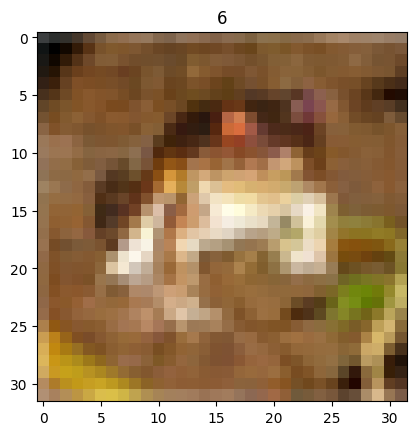

In [17]:
import matplotlib.pyplot as plt
img, label = cifar10[0]
plt.imshow(img)
plt.title(label)

## Transformer
Dữ liệu mình lấy được ở trên thì ảnh ở dạng PIL image, mình cần convert về dạng Torch tensor để cho Pytorch xử lý và tính toán. Module torchvision.transforms hỗ trợ các phép chuyển đổi trên ảnh như: chuyển sang tensor, normalization, augmentation,…

### To Tensor

In [18]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
# function convert PIL image to tensor
print(type(img))
img_tensor = to_tensor(img)
print(type(img_tensor))
print(img_tensor.shape)


<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
torch.Size([3, 32, 32])


Mình có thể transform trong lớp dataset khi load dữ liệu cifar10

In [19]:
tensor_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.ToTensor()
)
img_t, label = tensor_cifar10[99]
print(type(img_t))
print(type(label))

<class 'torch.Tensor'>
<class 'int'>


Ảnh ở dạng PIL image thì các pixel có giá trị từ 0-255, tuy nhiên khi chuyển về dạng tensor (ToTensor) thì dữ liệu pixel được scale về khoảng 0.0-1.0

In [20]:
print(img_t.min(), img_t.max())

tensor(0.) tensor(1.)


### Normalization
Việc normalization dữ liệu giúp các pixel có cùng scale cũng như distribution, do đó mình có thể dùng thuật toán gradient descent cho các tham số với cùng một learning rate. Thông thường mình sẽ normalize để mỗi channel về standard normal distribution (N(0, 1), normal distribution với 0 mean và 1 standard deviation)

$\displaystyle v[c] = \frac{v[c] - mean[c]}{std[c]}$

In [21]:
# imgs.view(3, -1).mean(dim=1) # tensor([0.4915, 0.4823, 0.4468])
# imgs.view(3, -1).std(dim=1) # tensor([0.2470, 0.2435, 0.2616])

### Compose
Ngoài ra Pytorch transforms còn hỗ trợ rất nhiều phép biển đổi khác như: RandomCrop, RandomRotation, RandomAffine (để shear), RandomHorizontalFlip,… Chi tiết mọi người xem ở [đây](https://pytorch.org/vision/stable/transforms.html).

Để thực hiện nhiều phép biến đổi trên dữ liệu đầu vào, transforms hỗ trợ hàm compose để gộp các transforms lại.

In [22]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
 (0.2470, 0.2435, 0.2616))
])

In [29]:
tensor_cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transform
)
tensor_cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transform
)

Như vậy là mình đã có Dataset và thực hiện transform các ảnh đưa về dạng tensor cũng như normalize các ảnh. Giờ mình cần lấy các ảnh cho quá trình traning.

## Dataloader
Khi cho dữ liệu vào model để học thì thông thường sẽ cho dữ liệu theo từng `batch` một, `DataLoader` sẽ giúp chúng ta lấy dữ liệu theo từng `batch`, `shuffle` dữ liệu cũng như load dữ liệu song song với nhiều `multiprocessing workers`.

In [37]:
train_loader = torch.utils.data.DataLoader(
    tensor_cifar10_train,
    batch_size=36,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    tensor_cifar10_val,
    batch_size=36,
    shuffle=True
)

## Train

### Model
Build a simple CNN

In [39]:
import torch.nn as nn
import torch.nn.functional as F
# model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        # bài toán phân loại 10 lớp nên output ra 10 nodes
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        # flatten về dạng vector để cho vào neural network
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
     

### Loss

In [27]:
loss_fn = nn.CrossEntropyLoss()

Lưu ý: Hàm CrossEntropyLoss của Pytorch đã bao gồm cả `activation softmax` ở lớp output và `categorial crossentropy loss` thế nên khi dựng `model` không cần dùng `activation softmax` ở `output layer`.

### Train

In [41]:
from tqdm import tqdm
def train_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in tqdm(train_loader):
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        correct = 0
        # Compute acc in valid dataset
        with torch.no_grad():
            for data in tqdm(val_loader):
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                correct += c.sum()
        if epoch == 1 or epoch%1 ==0:
            print('Epoch {}, Training loss {}, Valid accuracy {}'.format(
                epoch,
                loss_train/len(train_loader),
                correct/ len(val_loader)
            ) )

In [42]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-2)
loss_fn = nn.CrossEntropyLoss()

train_loop(
    n_epochs=30,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

 43%|████▎     | 599/1389 [00:20<00:27, 28.60it/s]


KeyboardInterrupt: 